In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from pandas import Series
import os 
from itertools import product

import warnings

#from modshogun import *

from sklearn import linear_model, decomposition
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold, LeaveOneGroupOut
from sklearn.externals.joblib import Parallel, delayed
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, Imputer, MinMaxScaler
from sklearn.pipeline import Pipeline

from CustomCVs import KFoldMixedSizes, StratifiedKFoldMixedSizes, StratifiedKFoldByGroups
#from evaluation_classifier import Evaluater

from time import time
from IPython.display import clear_output

#from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, IterativeSVD #, MICE

from six.moves import cPickle as pickle

import matplotlib.pyplot as plt

In [2]:
# def create_rank_k_dataset(
#         n_rows=5,
#         n_cols=5,
#         k=3,
#         fraction_missing=0.1,
#         symmetric=False,
#         random_seed=0):
#     np.random.seed(random_seed)
#     x = np.random.randn(n_rows, k)
#     y = np.random.randn(k, n_cols)

#     XY = np.dot(x, y)

#     if symmetric:
#         assert n_rows == n_cols
#         XY = 0.5 * XY + 0.5 * XY.T

#     missing_raw_values = np.random.uniform(0, 1, (n_rows, n_cols))
#     missing_mask = missing_raw_values < fraction_missing

#     XY_incomplete = XY.copy()
#     # fill missing entries with NaN
#     XY_incomplete[missing_mask] = np.nan

#     return XY, XY_incomplete, missing_mask

# # create some default data to be shared across tests
# XY, XY_incomplete, missing_mask = create_rank_k_dataset(
#     n_rows=500,
#     n_cols=10,
#     k=3,
#     fraction_missing=0.25)

In [2]:
def create_correlated_dataset(cov_mat, var_vec, mean_vec, n_obs = 2500):
    
    n_vars = cov_mat.shape[0]
    cov_mat = cov_mat + 0.5 * np.eye(n_vars) # regularize for stability

    FUDGE_var = 1.5
    FUDGE_mean = 0.6
    try:
        L = np.linalg.cholesky(cov_mat)
        D = np.dot(L, np.random.uniform(0,1, (n_vars, n_obs)))
        D = FUDGE_var*D*var_vec.T + FUDGE_mean*mean_vec.T # get the scaling right
        return D
    
    except np.linalg.LinAlgError as err:
        print('Error ---- Cholesksy')
        return None
        
    

In [3]:
# test
cov_mat = np.array([[1, 0.7, 0.7, 0.5,],
             [0.7, 1, 0.95, 0.3],
             [0.7, 0.95, 1, 0.3],
             [0.5, 0.3, 0.3, 1]])
mean_vec=np.array([200, 200, 200, 200], ndmin=2)
var_vec=np.array([100, 100, 100, 100], ndmin=2)

D = create_correlated_dataset(cov_mat, var_vec, mean_vec)
print(D.shape)
np.corrcoef(D)

(4, 2500)


array([[1.        , 0.46929269, 0.49214179, 0.32652244],
       [0.46929269, 1.        , 0.63966019, 0.22056709],
       [0.49214179, 0.63966019, 1.        , 0.21131443],
       [0.32652244, 0.22056709, 0.21131443, 1.        ]])

In [4]:
D

array([[191.56396732, 187.31088678, 223.20164568, ..., 234.65210773,
        175.13724453, 236.83522706],
       [186.74897668, 186.47043807, 277.52027845, ..., 237.34308385,
        299.58782595, 193.35239691],
       [273.46097801, 209.71894135, 267.35604988, ..., 225.30262773,
        314.55200158, 312.43062847],
       [253.73177461, 162.45075846, 229.84678942, ..., 300.44739523,
        193.06778509, 242.95604382]])

In [5]:
# Construct a cov matrix using a REAL dataset

data_dir="/data/rmthomas/HeteroSmallSample"
df = pd.read_csv(os.path.join(data_dir, "real_data.csv"))
df_numeric = df[df.columns[25:125]]

# cov_mat_overall = df_numeric.corr().values
# alpha = 0.2
# reg_cov_mat = cov_mat_overall + alpha*np.eye(100) # alpha makes the matrix well conditioned for Cholesky
# D_overall = create_correlated_dataset(reg_cov_mat)
# print(D_overall.shape)

In [6]:
n_features = 100 
g = df.groupby(['site', 'Dx', 'age_group'])[df.columns[25:25+n_features]]
Groups = list(g.indices.keys())

In [7]:
# Generate correlation matrices per set = (site, Dx, age_group)
corrs_per_set = g.corr().values.reshape(-1, n_features, n_features)
means_per_set = g.mean().values.reshape(-1, n_features)
vars_per_set = g.std().values.reshape(-1, n_features)
#corrs_per_set[np.where(np.isnan(corrs_per_set))] = 0.5

In [8]:
feature_labels = [f'f{i}' for i in range(100)] # f1, f2 ...f100
data_cols = ['site', 'Dx', 'Age_group'] + feature_labels

In [9]:
sim_data_all = pd.DataFrame(columns=data_cols) # initialize a dataframe
group_template = pd.DataFrame(columns=['site', 'Dx', 'Age_group']) # initialize a dataframe

sim_data=[]

min_subj = 20
max_subj = 120
for corr_i in range(corrs_per_set.shape[0]):
    n_obs=np.random.choice(np.arange(min_subj, max_subj))
    D = create_correlated_dataset(corrs_per_set[corr_i], vars_per_set[corr_i].reshape(1,n_features), means_per_set[corr_i].reshape(1,n_features), n_obs=n_obs)

    if D is not None:
        sim_data_group = pd.DataFrame([list(Groups[corr_i])], columns=['site', 'Dx', 'Age_group'])
        sim_data_group = pd.concat([sim_data_group]*n_obs, ignore_index=True)
        
        sim_data_group_matrix = pd.DataFrame(D.T, columns=feature_labels)
        df_group = pd.concat([sim_data_group, sim_data_group_matrix], axis=1, ignore_index=False)
        sim_data_all = sim_data_all.append(df_group, ignore_index=True)
        sim_data.append(D)

Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy
Error ---- Cholesksy


In [10]:
sim_data_all.shape

(3975, 103)

In [23]:
[sim_data_all.mean().values, df_numeric.mean().values]

[array([1.12295826e+03, 2.83240357e+03, 3.16672976e+03, 1.34195979e+03,
        4.73346740e+03, 6.17493193e+03, 7.02186019e+03, 5.35349764e+02,
        1.38686473e+03, 3.32656379e+03, 3.46925039e+03, 1.43302906e+03,
        4.96038813e+03, 6.24378893e+03, 6.99421012e+04, 9.51810812e+02,
        6.21513058e+02, 2.18448349e+03, 1.26703705e+03, 3.85857865e+02,
        1.87746170e+02, 3.00089642e+03, 4.56014032e+03, 3.26823609e+03,
        1.91708514e+03, 1.03625930e+03, 4.45436848e+03, 2.34049795e+03,
        2.84253832e+03, 1.75409821e+03, 3.05234714e+03, 1.24079370e+03,
        6.97006721e+02, 1.64250054e+03, 6.07061063e+02, 1.30044808e+03,
        1.32656291e+03, 4.02982578e+03, 1.20983145e+03, 4.50275296e+03,
        3.79082297e+03, 9.50054348e+02, 6.03807578e+03, 7.14043739e+03,
        5.30195166e+03, 3.73371973e+03, 4.13926531e+03, 4.33316441e+02,
        4.92652777e+02, 8.49666950e+04, 9.75166262e+02, 8.61015105e+02,
        2.39301123e+03, 1.55501280e+03, 3.67452821e+02, 2.744561

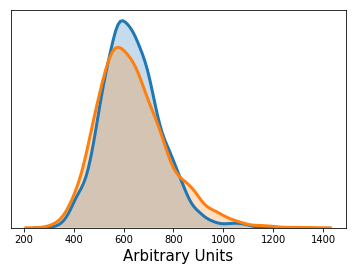

In [56]:
import seaborn as sns
i=16
g1 = sns.kdeplot(sim_data_all[f'f{i}'], legend=False, linewidth=3, shade=True)
_ = sns.kdeplot(df_numeric[~df_numeric[df_numeric.columns[i]].isna()][df_numeric.columns[i]], legend=False, linewidth=3,
                shade=True)
#sim_data_all.columns
g1.set(yticks=[])
g1.set_xlabel('Arbitrary Units', fontsize=15)

plt.savefig('compare_sim_kde.png')

#g2.set(yticks=[])

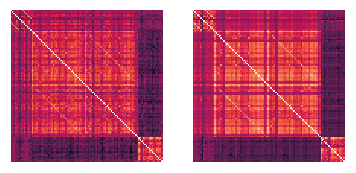

In [69]:
plt.subplot(1,2,1)
sns.heatmap(sim_data_all[sim_data_all.columns[3:]].corr(), xticklabels=[], yticklabels=[], cbar=False, square=True)
plt.subplot(1,2,2)
sns.heatmap(df_numeric.corr(), xticklabels=[], yticklabels=[], cbar=False, square=True)

#df_numeric.corr()

In [24]:
# Write it to file
sim_data_all.to_csv('simulated_data.csv')

In [ ]:
all_data = np.hstack(sim_data)
nvars, nsubjs = all_data.shape

In [ ]:
# Create data for each group
D_patients = create_correlated_dataset(cov_patients)
D_controls = create_correlated_dataset(cov_controls)

In [ ]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [ ]:
one_hot(np.array([1,1,0]),2)

In [ ]:
a = np.array([1,0,3])
out = (np.arange(4) == a[:,None]).astype(np.float32)
out

In [ ]:
np.arange(4)[None,:].shape

In [ ]:
np.arange(4)[None,:] == a[:,None]